# CNN mit "Fashion MNIST"

Zum Üben von CNN schauen wir uns ein Fallbeispiel an. Sehr häufig wird das Erkennen von handschriftlich geschriebenen Ziffern als Fallbeispiel genommen, das sogenannte **MNIST**-Beispiel.

Hier wollen wir uns ein ähnliches Beispiel anschauen, das aber umfangreicher und schwieriger ist, das sogenannte **Fashion-MNIST** von Zalando [Link](https://github.com/zalandoresearch/fashion-mnist).

Aufgabe ist es, anhand von 60000 Trainings- und 10000 schwarz-weißen Testbildern in Format 28x28 Pixeln einen Klassifikator zu trainieren, der in der Lage ist, ein Bild in eine von 10 Klassen für Modeartikeln einzuteilen.

## 1. Daten einlesen

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import fashion_mnist  # Fashion_MNIST ist ein beispielhafter Datensatz der TensorFlow-Library
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# Statistiken zum Datensatz ausgeben
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Die Ausgaben zeigen, daß wir in der Trainingsmenge X_train 60'000 Bilder mit 28x28 Pixel haben und in der Testmenge 10'000.

Schauen wir uns die Labels an

In [4]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


Da wir für die Zielklassen nur Zahlen und keine Namen haben, speichern wir diese separat.

In [5]:
class_names = ['T-shirt/ Top',
               'Hose', 
               'Pullover', 
               'Kleid', 
               'Mantel',
               'Sandale',
               'Hemd',
               'Sneaker', 
               'Tasche', 
               'Stiefel']

Wir lassen in diesem Notebook Image Augmentation aus. In diesem Notebook geht es mehr darum, daß Sie mit den Hyperparametern experimentieren und sehen, wie die Struktur eines CNN Auswirkungen auf die Genauigkeit des Lernens hat.

Deshalb normalisieren wir nur die Bilder als einzige "Augmentation".

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Schauen wir uns nun die Bilder mal an. Und geben dazu das Label aus

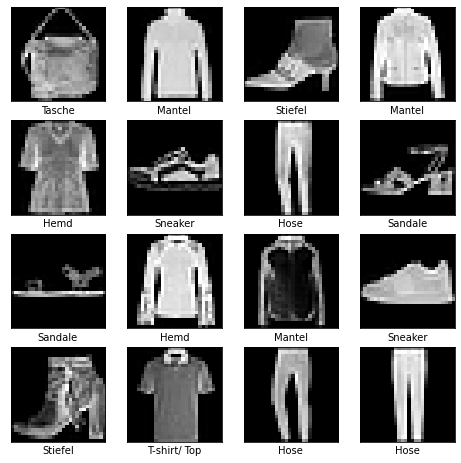

In [7]:
import matplotlib.pyplot as plt

number_cols = 4
number_rows = 4
run_index = 0

plt.figure(1 , figsize = (8 , 8))

for i in range(number_cols * number_rows):
  run_index += 1
  cur_plot = plt.subplot(number_cols, number_rows, run_index)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  pic_index = np.random.randint(0, 60000) # wähle ein zufälliges Bild
  plt.imshow(X_train[pic_index], cmap=plt.get_cmap('gray')) 
  plt.xlabel(class_names[y_train[pic_index]])

  #cur_plot.axis('Off') # Keine Achsen zeigen
plt.show()

Als letzten Schritt bauen wir noch schnell das Datenset um.
Wir haben folgende Struktur von X_Train und X_Test:
Anzahl Bilder * x_pixel * y_Pixel.

Wir wollen eine zusätzliche Ebene für den grauen Farbkanal haben:
Anzahl Bilder * x_pixel * y_Pixel * Farbkanal


In [8]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

## 2. Machine Learning: Wir bauen ein CNN

In [9]:
import tensorflow.keras   # Keras als Schnittstelle zu den "komplizierteren Umfängen"
from tensorflow.keras import layers
from tensorflow.keras import Model

INPUT_SHAPE = (28,28, 1) # wie oben gezeigt, hat jedes Bild 28x28 Pixel. Da wir die Bilder nur in Graustaufen haben, gibt es zusätzlich nur 1 Kanal.

num_target_classes = 10 # wir haben 10 Zielklassen

# wir bauen den Input Layer. Jeder Pixel ist ein Input für das CNN.
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

# ab hier
# wir bauen den ersten Bildverarbeitungs-Layer. Erst Faltung, dann Pooling, dann Droput
conv1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(inp)

pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2)) (conv1)
drop1 = tf.keras.layers.Dropout(0.5) (pool1)

# wir bauen den 2. Bildverarbeitungs-Layer. Erst Faltung, dann Pooling, dann Droput
conv2 = tf.keras.layers.Conv2D(64, 
                               kernel_size=(3, 3), 
                               activation='relu',
                               padding='same') (drop1)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#drop2 = tf.keras.layers.Dropout(0.5) (pool2)  # vor Flatten nimmt man kein Pooling. 

# nach dem 2. Bildverarbeitungs-Layer geben wir die Daten in ein "normales" CNN rein.
flat = tf.keras.layers.Flatten()(pool2)

# hier der erste Hidden Layer des CNN
hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop3 = tf.keras.layers.Dropout(rate=0.5)(hidden1)

# hier der zweite Hidden Layer des CNN
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop3)
drop4 = tf.keras.layers.Dropout(rate=0.5)(hidden2)

# und hier gehts raus aus dem CNN. Wichtig ist die Wahl des Dense Layers und der Softmax-Aktivierungsfunktion. Diese brauchen wir, da wir mit dieser das Ergebnis klassifizieren können.
# Als Ergebnis erhalten wir für jede mögliche Zielklasse einen Wert. Out erhält dann den Wert, der die höchste Wahrscheinlichkeit hat.
out = tf.keras.layers.Dense(num_target_classes, activation='softmax')(drop4)

# jetzt speichern wir die ganze Struktur in ein Modell
model = tf.keras.Model(inputs=inp, outputs=out)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                         

Nachdem wir das Modell gebaut haben, definieren wir jetzt die Hyperparameter

* Batch_size: wie viele Samples werden aus der Trainingsmenge genommen bevor die Gewichte und Bias des Modells angepaßt werden. Im unteren Fall heißt das, nach 256 Bildern passen wir die Gewichte an.
* Epochen: wie viele Durchläufe durch das gesamte Datenset werden gemacht.
* Learning_rate: Geschwindigkeit mit der das Modell lernt. Genauer gesagt stellt es die Schrittweite dar, die bei jeder Iteration gegangen wird, um das Minimum der Loss-Funktion zu erreichen.
* Optimizer: Algorithmus der eingesetzt wird, um die Gewichte und Bias so zu reduzieren, daß die Loss-Funktion minimiert wird.

Diese Parameter ermöglichen deutliche Verbesserungen des Ergebnisses und stehen auch miteinander in Verbindung (bspw. small batch size sollte mit niedriger Lernrate kombiniert werden).

Nachdem wir das gemacht haben, starten wir das Trainieren des Models.

In [11]:
BATCH_SIZE = 256
EPOCHS = 30 # für Testzwecke nicht mehr als 30 nehmen
INIT_LEARNING_RATE = 0.001

opt = tf.keras.optimizers.Adam(learning_rate = INIT_LEARNING_RATE,
                                     decay=INIT_LEARNING_RATE / EPOCHS)

model.compile(optimizer=opt, 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

Jetzt definieren wir die Trainingsparameter

In [12]:
history = model.fit(x=X_train,
                    y= y_train,
                    validation_data = (X_test, y_test),
                    batch_size=BATCH_SIZE,
                    epochs = EPOCHS,
                    use_multiprocessing=True)

Epoch 1/30
235/235 [==============================] - 21s 35ms/step - loss: 0.6817 - accuracy: 0.7479 - val_loss: 0.3866 - val_accuracy: 0.8563
Epoch 2/30
235/235 [==============================] - 8s 34ms/step - loss: 0.3937 - accuracy: 0.8602 - val_loss: 0.3529 - val_accuracy: 0.8687
Epoch 3/30
235/235 [==============================] - 8s 34ms/step - loss: 0.3412 - accuracy: 0.8765 - val_loss: 0.2981 - val_accuracy: 0.8911
Epoch 4/30
235/235 [==============================] - 8s 34ms/step - loss: 0.3036 - accuracy: 0.8900 - val_loss: 0.2716 - val_accuracy: 0.9006
Epoch 5/30
235/235 [==============================] - 8s 34ms/step - loss: 0.2785 - accuracy: 0.8986 - val_loss: 0.2570 - val_accuracy: 0.9082
Epoch 6/30
235/235 [==============================] - 8s 34ms/step - loss: 0.2626 - accuracy: 0.9043 - val_loss: 0.2509 - val_accuracy: 0.9093
Epoch 7/30
235/235 [==============================] - 8s 34ms/step - loss: 0.2443 - accuracy: 0.9106 - val_loss: 0.2404 - val_accuracy: 0.909

Nach dem Training schauen wir uns jetzt an, wie hoch die Genauigkeit ist.

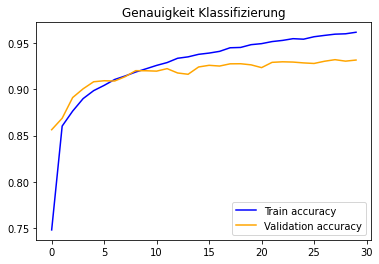

In [13]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung')
plt.plot(history.history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.legend()
plt.show()

# 3. Testen des Modells

In [14]:
def classify_pic(samplePicture, picindex):
  samplePicture /= 255.                                      # Bild normalisieren
  sample_pic_aufbereitet = samplePicture.reshape (1, 28, 28, 1)

  predicted_model = model.predict(sample_pic_aufbereitet)
        
  temp_picture = samplePicture.reshape(28,28) # wir löschen den Schwarz-weiß Kanal fürs Anzeigen des Bildes

  plt.imshow(temp_picture)
  plt.xlabel(class_names[y_test[picindex]])

  plt.show()
  
  plt.bar(range(10), predicted_model[0])
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  
  print("Klasse vorhergesagt: {}".format(class_names[np.argmax(predicted_model[0])]))

  print("Gesamte Wahrscheinlichkeiten:")

  #print(class_names[np.argmax(predicted_model)])

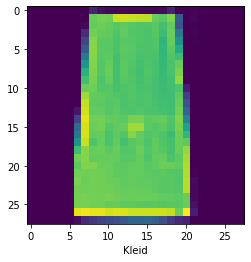

Klasse vorhergesagt: T-shirt/ Top
Gesamte Wahrscheinlichkeiten:


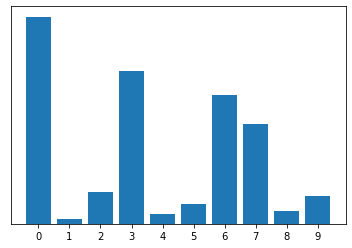

In [15]:
classify_pic(X_test[42], 42)

Nachdem Sie jetzt einen gesamten Durchlauf gesehen haben, sind Sie an der Reihe!

Probieren Sie verschiedene CNN-Strukturen aus: wie ändert sich dabei die Genauigkeit des Modells?

* Anpassungen der bestehenden Conv2D-Faltungen: Anzahl Filter (erste Zahl), Kernel, Padding, Aktivierungsfunktionen
* Mehrere neue Faltungen (Conv2D)
* MaxPooling2D: Größe des Pooling 
* Dropout: Prozentsatz
* Anpassungen der bestehenden Dense-Layers
* Neue Dense-Layers

Probieren Sie verschiedene Hyperparameter aus: wie ändert sich dabei die Genauigkeit des Modells?
* BATCH_SIZE 
* EPOCHS
* LEARNING_RATE